In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

In [3]:
import keras
from keras_unet.models import custom_unet


2023-01-07 10:15:09.900257: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [4]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [5]:
images = np.load(images_file)
labels = np.load(labels_file)

In [6]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [7]:
p = np.random.permutation(len(images))

In [8]:
images = images[p]
labels = labels[p]

In [9]:
labels = labels.astype(np.float64)

In [10]:
images = images.astype(np.float64)

for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [11]:
images.shape

(503, 512, 512, 1)

In [12]:
X_train = images[0:300]
y_train = labels[0:300]
X_val = images[300:400]
y_val = labels[300:400]
X_test = images[400:]
y_test = labels[400:]

In [13]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 512, 512, 1) (2, 512, 512, 1)


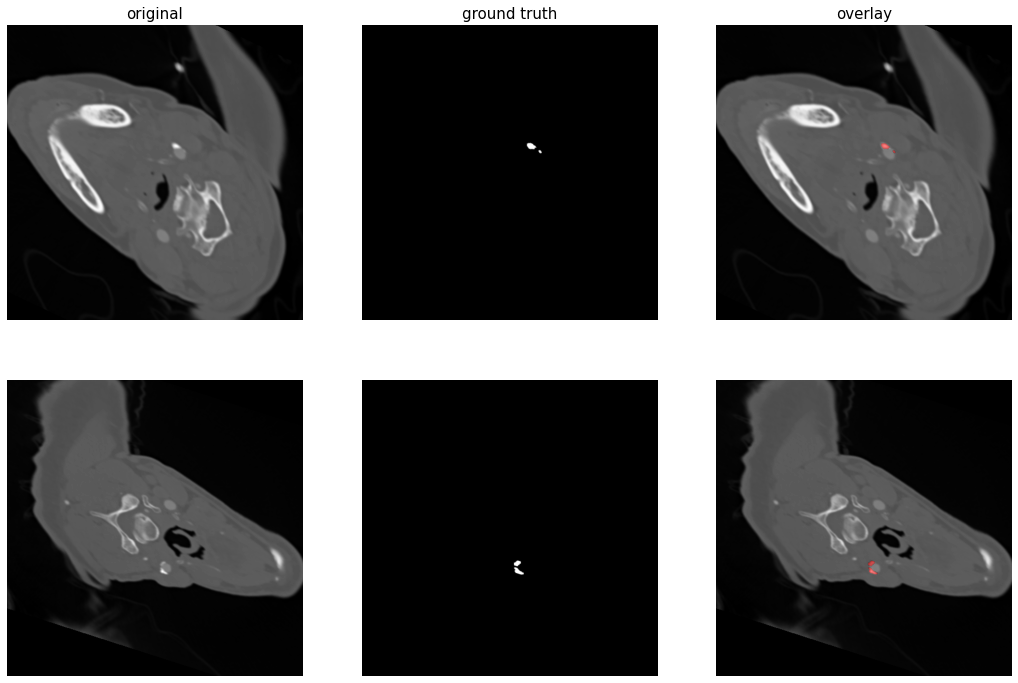

In [14]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [15]:

model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.5,
    output_activation='sigmoid')

2023-01-07 10:15:19.362281: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-01-07 10:15:19.448714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-01-07 10:15:19.448755: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-01-07 10:15:19.451829: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-07 10:15:19.451864: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-01-07 10:15:19.452707: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 512, 512, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       spatial_dropout2d[0][0]          
______________________________________________________________________________________________

In [17]:
import keras.optimizers
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

In [18]:
opt = keras.optimizer_v1.Adam(lr=0.01)

In [19]:
model.compile(optimizer = 'Adam',    
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [20]:
history = model.fit(X_train, 
                    y_train, 
                    32, 
                    epochs=600,
                    validation_data=(X_val, y_val))

2023-01-07 10:15:21.021519: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-07 10:15:21.041173: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/600


2023-01-07 10:15:22.224428: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-01-07 10:15:22.949399: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-01-07 10:15:23.608794: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-01-07 10:15:23.608820: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-01-07 10:15:23.608885: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-01-07 10:15:23.690796: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-07 10:15:24.397951: I tensorflow/stream_exec

10/10 [==============================] - 43s 2s/step - loss: 0.4717 - iou: 1.9256e-04 - iou_thresholded: 5.4786e-04 - val_loss: 0.0219 - val_iou: 3.0587e-05 - val_iou_thresholded: 0.0025
Epoch 2/600
10/10 [==============================] - 10s 962ms/step - loss: 0.0502 - iou: 8.2560e-05 - iou_thresholded: 7.6654e-04 - val_loss: 0.0570 - val_iou: 3.5633e-05 - val_iou_thresholded: 0.0025
Epoch 3/600
10/10 [==============================] - 10s 960ms/step - loss: 0.0122 - iou: 1.7320e-04 - iou_thresholded: 6.8050e-04 - val_loss: 0.0035 - val_iou: 2.2940e-04 - val_iou_thresholded: 0.0025
Epoch 4/600
10/10 [==============================] - 10s 955ms/step - loss: 0.0047 - iou: 1.3879e-04 - iou_thresholded: 5.6054e-04 - val_loss: 0.0044 - val_iou: 4.3150e-04 - val_iou_thresholded: 0.0025
Epoch 5/600
10/10 [==============================] - 10s 957ms/step - loss: 0.0032 - iou: 3.1540e-04 - iou_thresholded: 7.0598e-04 - val_loss: 0.0047 - val_iou: 4.8773e-04 - val_iou_thresholded: 0.0025
Epoch

Epoch 43/600
10/10 [==============================] - 10s 958ms/step - loss: 0.0014 - iou: 0.0080 - iou_thresholded: 6.0943e-04 - val_loss: 0.0015 - val_iou: 0.0059 - val_iou_thresholded: 0.0025
Epoch 44/600
10/10 [==============================] - 10s 955ms/step - loss: 0.0014 - iou: 0.0095 - iou_thresholded: 6.5887e-04 - val_loss: 0.0014 - val_iou: 0.0078 - val_iou_thresholded: 0.0025
Epoch 45/600
10/10 [==============================] - 10s 956ms/step - loss: 0.0014 - iou: 0.0089 - iou_thresholded: 5.9502e-04 - val_loss: 0.0014 - val_iou: 0.0062 - val_iou_thresholded: 0.0025
Epoch 46/600
10/10 [==============================] - 10s 962ms/step - loss: 0.0014 - iou: 0.0095 - iou_thresholded: 5.9761e-04 - val_loss: 0.0015 - val_iou: 0.0059 - val_iou_thresholded: 0.0025
Epoch 47/600
10/10 [==============================] - 10s 957ms/step - loss: 0.0014 - iou: 0.0091 - iou_thresholded: 5.9203e-04 - val_loss: 0.0013 - val_iou: 0.0076 - val_iou_thresholded: 0.0025
Epoch 48/600
10/10 [=====

Epoch 85/600
10/10 [==============================] - 10s 957ms/step - loss: 6.6014e-04 - iou: 0.2094 - iou_thresholded: 0.2984 - val_loss: 6.6646e-04 - val_iou: 0.1629 - val_iou_thresholded: 0.2096
Epoch 86/600
10/10 [==============================] - 10s 958ms/step - loss: 6.9136e-04 - iou: 0.2042 - iou_thresholded: 0.2885 - val_loss: 6.4067e-04 - val_iou: 0.1662 - val_iou_thresholded: 0.2286
Epoch 87/600
10/10 [==============================] - 10s 956ms/step - loss: 6.3326e-04 - iou: 0.2239 - iou_thresholded: 0.3102 - val_loss: 6.0945e-04 - val_iou: 0.1891 - val_iou_thresholded: 0.2498
Epoch 88/600
10/10 [==============================] - 10s 955ms/step - loss: 6.3647e-04 - iou: 0.2237 - iou_thresholded: 0.3191 - val_loss: 7.1751e-04 - val_iou: 0.1739 - val_iou_thresholded: 0.1797
Epoch 89/600
10/10 [==============================] - 10s 960ms/step - loss: 6.4014e-04 - iou: 0.2373 - iou_thresholded: 0.3233 - val_loss: 6.5177e-04 - val_iou: 0.1739 - val_iou_thresholded: 0.2367
Epoch

10/10 [==============================] - 10s 955ms/step - loss: 4.6241e-04 - iou: 0.3479 - iou_thresholded: 0.4756 - val_loss: 4.7288e-04 - val_iou: 0.3029 - val_iou_thresholded: 0.3782
Epoch 127/600
10/10 [==============================] - 10s 960ms/step - loss: 4.3647e-04 - iou: 0.3670 - iou_thresholded: 0.4930 - val_loss: 5.0102e-04 - val_iou: 0.2936 - val_iou_thresholded: 0.3623
Epoch 128/600
10/10 [==============================] - 10s 958ms/step - loss: 4.4461e-04 - iou: 0.3424 - iou_thresholded: 0.4428 - val_loss: 4.7585e-04 - val_iou: 0.2870 - val_iou_thresholded: 0.3939
Epoch 129/600
10/10 [==============================] - 10s 955ms/step - loss: 4.3976e-04 - iou: 0.3463 - iou_thresholded: 0.4693 - val_loss: 5.1255e-04 - val_iou: 0.2530 - val_iou_thresholded: 0.4116
Epoch 130/600
10/10 [==============================] - 10s 957ms/step - loss: 4.4023e-04 - iou: 0.3436 - iou_thresholded: 0.4781 - val_loss: 4.9248e-04 - val_iou: 0.3066 - val_iou_thresholded: 0.3628
Epoch 131/600


10/10 [==============================] - 10s 955ms/step - loss: 3.4619e-04 - iou: 0.4245 - iou_thresholded: 0.5537 - val_loss: 4.0705e-04 - val_iou: 0.3660 - val_iou_thresholded: 0.4549
Epoch 168/600
10/10 [==============================] - 10s 958ms/step - loss: 3.3165e-04 - iou: 0.4439 - iou_thresholded: 0.5626 - val_loss: 3.9037e-04 - val_iou: 0.3629 - val_iou_thresholded: 0.4573
Epoch 169/600
10/10 [==============================] - 10s 955ms/step - loss: 3.4088e-04 - iou: 0.4365 - iou_thresholded: 0.5602 - val_loss: 3.9323e-04 - val_iou: 0.3635 - val_iou_thresholded: 0.4705
Epoch 170/600
10/10 [==============================] - 10s 956ms/step - loss: 3.4136e-04 - iou: 0.4374 - iou_thresholded: 0.5668 - val_loss: 4.1660e-04 - val_iou: 0.3554 - val_iou_thresholded: 0.4277
Epoch 171/600
10/10 [==============================] - 10s 963ms/step - loss: 3.3888e-04 - iou: 0.4399 - iou_thresholded: 0.5619 - val_loss: 4.0610e-04 - val_iou: 0.3561 - val_iou_thresholded: 0.4334
Epoch 172/600


10/10 [==============================] - 10s 956ms/step - loss: 2.8721e-04 - iou: 0.4909 - iou_thresholded: 0.6063 - val_loss: 3.7181e-04 - val_iou: 0.3990 - val_iou_thresholded: 0.5023
Epoch 209/600
10/10 [==============================] - 10s 961ms/step - loss: 2.8736e-04 - iou: 0.4867 - iou_thresholded: 0.6062 - val_loss: 3.5010e-04 - val_iou: 0.3920 - val_iou_thresholded: 0.5168
Epoch 210/600
10/10 [==============================] - 10s 956ms/step - loss: 2.8841e-04 - iou: 0.4899 - iou_thresholded: 0.6114 - val_loss: 4.0088e-04 - val_iou: 0.4032 - val_iou_thresholded: 0.4630
Epoch 211/600
10/10 [==============================] - 10s 957ms/step - loss: 2.9654e-04 - iou: 0.4898 - iou_thresholded: 0.6003 - val_loss: 3.6757e-04 - val_iou: 0.3853 - val_iou_thresholded: 0.4931
Epoch 212/600
10/10 [==============================] - 10s 959ms/step - loss: 2.9431e-04 - iou: 0.4893 - iou_thresholded: 0.6074 - val_loss: 3.6828e-04 - val_iou: 0.3746 - val_iou_thresholded: 0.5112
Epoch 213/600


10/10 [==============================] - 10s 957ms/step - loss: 2.5908e-04 - iou: 0.5253 - iou_thresholded: 0.6411 - val_loss: 3.4686e-04 - val_iou: 0.4104 - val_iou_thresholded: 0.5053
Epoch 250/600
10/10 [==============================] - 10s 955ms/step - loss: 2.5207e-04 - iou: 0.5330 - iou_thresholded: 0.6469 - val_loss: 3.5030e-04 - val_iou: 0.4171 - val_iou_thresholded: 0.5130
Epoch 251/600
10/10 [==============================] - 10s 954ms/step - loss: 2.6103e-04 - iou: 0.5295 - iou_thresholded: 0.6496 - val_loss: 3.4629e-04 - val_iou: 0.4184 - val_iou_thresholded: 0.5090
Epoch 252/600
10/10 [==============================] - 10s 959ms/step - loss: 2.4546e-04 - iou: 0.5380 - iou_thresholded: 0.6500 - val_loss: 3.5568e-04 - val_iou: 0.4044 - val_iou_thresholded: 0.5148
Epoch 253/600
10/10 [==============================] - 10s 964ms/step - loss: 2.4988e-04 - iou: 0.5334 - iou_thresholded: 0.6490 - val_loss: 3.5634e-04 - val_iou: 0.4194 - val_iou_thresholded: 0.5000
Epoch 254/600


10/10 [==============================] - 10s 962ms/step - loss: 2.2110e-04 - iou: 0.5700 - iou_thresholded: 0.6741 - val_loss: 3.7226e-04 - val_iou: 0.4144 - val_iou_thresholded: 0.4610
Epoch 291/600
10/10 [==============================] - 10s 959ms/step - loss: 2.2591e-04 - iou: 0.5663 - iou_thresholded: 0.6718 - val_loss: 3.4103e-04 - val_iou: 0.3945 - val_iou_thresholded: 0.5180
Epoch 292/600
10/10 [==============================] - 10s 955ms/step - loss: 2.2733e-04 - iou: 0.5565 - iou_thresholded: 0.6720 - val_loss: 3.5066e-04 - val_iou: 0.4253 - val_iou_thresholded: 0.4871
Epoch 293/600
10/10 [==============================] - 10s 958ms/step - loss: 2.2470e-04 - iou: 0.5655 - iou_thresholded: 0.6714 - val_loss: 3.6974e-04 - val_iou: 0.4151 - val_iou_thresholded: 0.4656
Epoch 294/600
10/10 [==============================] - 10s 958ms/step - loss: 2.1764e-04 - iou: 0.5723 - iou_thresholded: 0.6759 - val_loss: 3.3800e-04 - val_iou: 0.4153 - val_iou_thresholded: 0.5107
Epoch 295/600


10/10 [==============================] - 10s 957ms/step - loss: 1.9295e-04 - iou: 0.6155 - iou_thresholded: 0.7162 - val_loss: 3.2653e-04 - val_iou: 0.4467 - val_iou_thresholded: 0.5268
Epoch 332/600
10/10 [==============================] - 10s 954ms/step - loss: 1.8393e-04 - iou: 0.6266 - iou_thresholded: 0.7239 - val_loss: 3.6776e-04 - val_iou: 0.4297 - val_iou_thresholded: 0.4814
Epoch 333/600
10/10 [==============================] - 10s 960ms/step - loss: 1.7991e-04 - iou: 0.6283 - iou_thresholded: 0.7241 - val_loss: 3.3517e-04 - val_iou: 0.4428 - val_iou_thresholded: 0.5349
Epoch 334/600
10/10 [==============================] - 10s 961ms/step - loss: 1.7573e-04 - iou: 0.6361 - iou_thresholded: 0.7274 - val_loss: 3.3925e-04 - val_iou: 0.4497 - val_iou_thresholded: 0.5381
Epoch 335/600
10/10 [==============================] - 10s 956ms/step - loss: 1.7941e-04 - iou: 0.6290 - iou_thresholded: 0.7231 - val_loss: 3.5469e-04 - val_iou: 0.4462 - val_iou_thresholded: 0.5112
Epoch 336/600


10/10 [==============================] - 10s 961ms/step - loss: 1.7343e-04 - iou: 0.6461 - iou_thresholded: 0.7499 - val_loss: 4.1386e-04 - val_iou: 0.4207 - val_iou_thresholded: 0.4568
Epoch 373/600
10/10 [==============================] - 10s 957ms/step - loss: 1.6401e-04 - iou: 0.6603 - iou_thresholded: 0.7443 - val_loss: 3.3815e-04 - val_iou: 0.4452 - val_iou_thresholded: 0.5302
Epoch 374/600
10/10 [==============================] - 10s 955ms/step - loss: 1.5460e-04 - iou: 0.6703 - iou_thresholded: 0.7614 - val_loss: 3.6240e-04 - val_iou: 0.4497 - val_iou_thresholded: 0.5089
Epoch 375/600
10/10 [==============================] - 10s 957ms/step - loss: 1.4847e-04 - iou: 0.6762 - iou_thresholded: 0.7637 - val_loss: 3.3911e-04 - val_iou: 0.4573 - val_iou_thresholded: 0.5452
Epoch 376/600
10/10 [==============================] - 10s 959ms/step - loss: 1.4408e-04 - iou: 0.6825 - iou_thresholded: 0.7737 - val_loss: 3.5994e-04 - val_iou: 0.4686 - val_iou_thresholded: 0.5315
Epoch 377/600


10/10 [==============================] - 10s 957ms/step - loss: 1.1676e-04 - iou: 0.7392 - iou_thresholded: 0.8155 - val_loss: 4.0454e-04 - val_iou: 0.4754 - val_iou_thresholded: 0.5249
Epoch 414/600
10/10 [==============================] - 10s 954ms/step - loss: 1.0824e-04 - iou: 0.7519 - iou_thresholded: 0.8296 - val_loss: 3.9341e-04 - val_iou: 0.4766 - val_iou_thresholded: 0.5359
Epoch 415/600
10/10 [==============================] - 10s 959ms/step - loss: 1.1084e-04 - iou: 0.7502 - iou_thresholded: 0.8236 - val_loss: 3.9710e-04 - val_iou: 0.4600 - val_iou_thresholded: 0.5436
Epoch 416/600
10/10 [==============================] - 10s 960ms/step - loss: 1.1093e-04 - iou: 0.7471 - iou_thresholded: 0.8243 - val_loss: 4.5197e-04 - val_iou: 0.4678 - val_iou_thresholded: 0.5037
Epoch 417/600
10/10 [==============================] - 10s 955ms/step - loss: 1.1471e-04 - iou: 0.7464 - iou_thresholded: 0.8232 - val_loss: 3.8327e-04 - val_iou: 0.4640 - val_iou_thresholded: 0.5305
Epoch 418/600


10/10 [==============================] - 10s 960ms/step - loss: 7.5333e-05 - iou: 0.8173 - iou_thresholded: 0.8778 - val_loss: 4.8287e-04 - val_iou: 0.4920 - val_iou_thresholded: 0.5272
Epoch 455/600
10/10 [==============================] - 10s 954ms/step - loss: 7.2472e-05 - iou: 0.8240 - iou_thresholded: 0.8841 - val_loss: 4.7198e-04 - val_iou: 0.4838 - val_iou_thresholded: 0.5238
Epoch 456/600
10/10 [==============================] - 10s 957ms/step - loss: 7.4036e-05 - iou: 0.8182 - iou_thresholded: 0.8809 - val_loss: 4.7264e-04 - val_iou: 0.4875 - val_iou_thresholded: 0.5250
Epoch 457/600
10/10 [==============================] - 10s 954ms/step - loss: 6.7462e-05 - iou: 0.8318 - iou_thresholded: 0.8916 - val_loss: 5.0550e-04 - val_iou: 0.5013 - val_iou_thresholded: 0.5364
Epoch 458/600
10/10 [==============================] - 10s 954ms/step - loss: 7.4597e-05 - iou: 0.8329 - iou_thresholded: 0.8874 - val_loss: 4.5621e-04 - val_iou: 0.4983 - val_iou_thresholded: 0.5430
Epoch 459/600


10/10 [==============================] - 10s 957ms/step - loss: 4.1914e-05 - iou: 0.8922 - iou_thresholded: 0.9350 - val_loss: 6.0742e-04 - val_iou: 0.5058 - val_iou_thresholded: 0.5302
Epoch 496/600
10/10 [==============================] - 10s 963ms/step - loss: 4.7307e-05 - iou: 0.8840 - iou_thresholded: 0.9282 - val_loss: 5.7376e-04 - val_iou: 0.5039 - val_iou_thresholded: 0.5421
Epoch 497/600
10/10 [==============================] - 10s 957ms/step - loss: 4.1381e-05 - iou: 0.8903 - iou_thresholded: 0.9348 - val_loss: 6.6290e-04 - val_iou: 0.5076 - val_iou_thresholded: 0.5299
Epoch 498/600
10/10 [==============================] - 10s 961ms/step - loss: 3.8958e-05 - iou: 0.9014 - iou_thresholded: 0.9413 - val_loss: 6.6287e-04 - val_iou: 0.5039 - val_iou_thresholded: 0.5239
Epoch 499/600
10/10 [==============================] - 10s 954ms/step - loss: 4.1601e-05 - iou: 0.8976 - iou_thresholded: 0.9389 - val_loss: 6.0941e-04 - val_iou: 0.5000 - val_iou_thresholded: 0.5254
Epoch 500/600


10/10 [==============================] - 10s 960ms/step - loss: 2.8666e-05 - iou: 0.9285 - iou_thresholded: 0.9564 - val_loss: 7.1919e-04 - val_iou: 0.5179 - val_iou_thresholded: 0.5375
Epoch 537/600
10/10 [==============================] - 10s 954ms/step - loss: 2.5844e-05 - iou: 0.9304 - iou_thresholded: 0.9599 - val_loss: 7.2968e-04 - val_iou: 0.5038 - val_iou_thresholded: 0.5153
Epoch 538/600
10/10 [==============================] - 10s 961ms/step - loss: 2.8455e-05 - iou: 0.9318 - iou_thresholded: 0.9576 - val_loss: 7.0536e-04 - val_iou: 0.4985 - val_iou_thresholded: 0.5175
Epoch 539/600
10/10 [==============================] - 10s 954ms/step - loss: 2.9008e-05 - iou: 0.9308 - iou_thresholded: 0.9581 - val_loss: 7.3673e-04 - val_iou: 0.5080 - val_iou_thresholded: 0.5275
Epoch 540/600
10/10 [==============================] - 10s 956ms/step - loss: 2.5838e-05 - iou: 0.9330 - iou_thresholded: 0.9625 - val_loss: 7.6303e-04 - val_iou: 0.5163 - val_iou_thresholded: 0.5339
Epoch 541/600


10/10 [==============================] - 10s 954ms/step - loss: 2.4061e-05 - iou: 0.9454 - iou_thresholded: 0.9680 - val_loss: 8.0097e-04 - val_iou: 0.4964 - val_iou_thresholded: 0.5120
Epoch 578/600
10/10 [==============================] - 10s 967ms/step - loss: 3.5682e-05 - iou: 0.9209 - iou_thresholded: 0.9457 - val_loss: 7.6280e-04 - val_iou: 0.4886 - val_iou_thresholded: 0.5012
Epoch 579/600
10/10 [==============================] - 10s 964ms/step - loss: 3.3208e-05 - iou: 0.9238 - iou_thresholded: 0.9523 - val_loss: 6.7145e-04 - val_iou: 0.5101 - val_iou_thresholded: 0.5331
Epoch 580/600
10/10 [==============================] - 10s 961ms/step - loss: 3.4455e-05 - iou: 0.9213 - iou_thresholded: 0.9533 - val_loss: 6.8377e-04 - val_iou: 0.4933 - val_iou_thresholded: 0.5158
Epoch 581/600
10/10 [==============================] - 10s 958ms/step - loss: 3.5246e-05 - iou: 0.9255 - iou_thresholded: 0.9563 - val_loss: 6.6215e-04 - val_iou: 0.5064 - val_iou_thresholded: 0.5320
Epoch 582/600


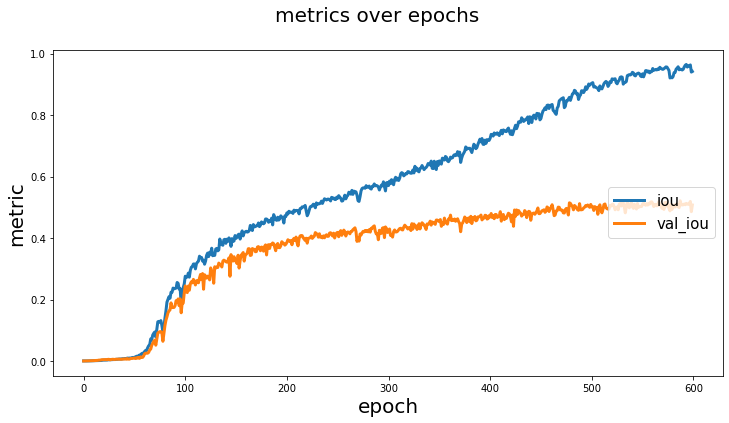

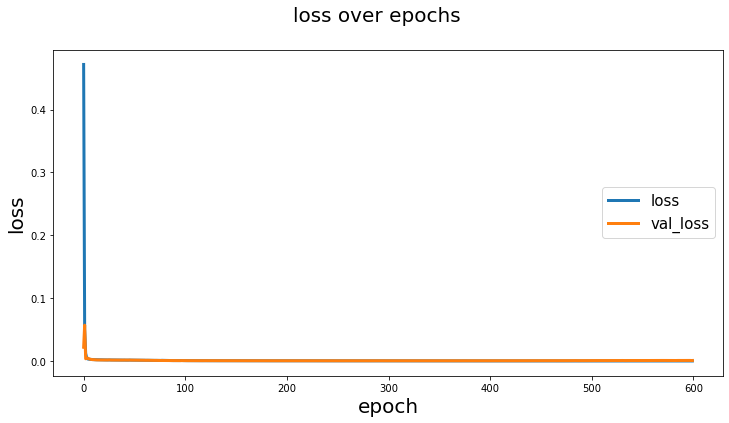

In [21]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [22]:
y_pred = model.predict(X_test)

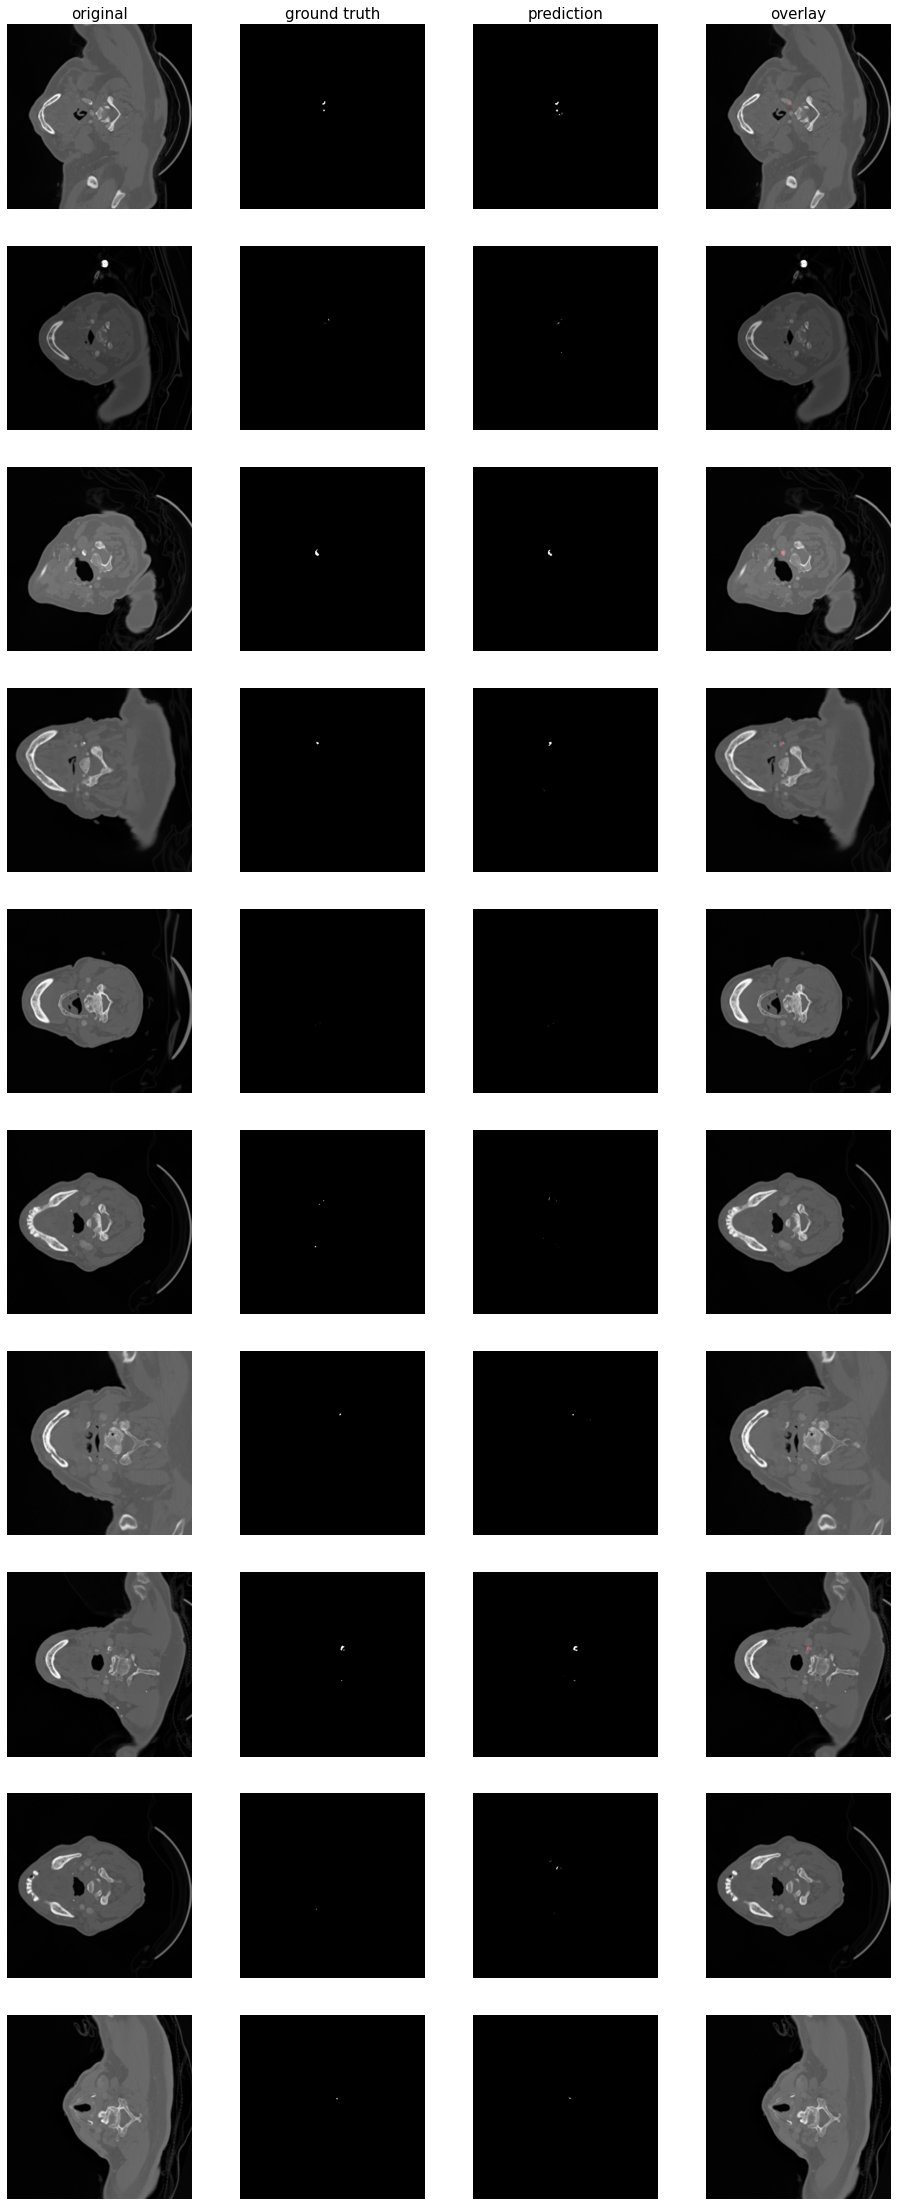

In [23]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)

In [24]:
loss, iou, iou_thresholded = model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 161ms/step - loss: 7.6011e-04 - iou: 0.5364 - iou_thresholded: 0.5551
